In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
from datetime import datetime
from datetime import date
from matplotlib import colors
from matplotlib import font_manager
from matplotlib import pyplot
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import netCDF4
import numpy
import os
import pandas
from PIL import Image
import random
import readline
import scipy
from scipy import fft
from scipy import linalg
from scipy import stats
from scipy.stats import poisson, ttest_ind
import seaborn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg
import xarray as xr

In [2]:
# Create Function For Finding Files
def Find_File(Year, k):
# .dat or .txt
    if Year >= 2011:
        End = '.dat'
    else:
        End = '.txt'
# Single Digit or Double Digit
    if k+1 <= 9:
        Code = 'wp0'+str(k+1)+str(Year)
    elif Year != 2015 and Year != 2002 and Year != 1997 and Year != 1995 and Year != 1989:
        Code = 'wp'+str(k+1)+str(Year)
# Years With Unusual Patterns
    elif Year == 2015:
        if k+1 <= 29:
            Code = 'wp'+str(k+1)+str(Year)
        elif k+1 == 30:
            Code = 'cp01'+str(Year)
        elif k+1 == 31:
            Code = 'cp03'+str(Year)
    elif Year == 2002:
        if k+1 <= 31:
            Code = 'wp'+str(k+1)+str(Year)
        elif k+1 == 32:
            Code = 'cp02'+str(Year)
        elif k+1 == 33:
            Code = 'cp03'+str(Year)
    elif Year == 1997:
        if k+1 <= 31:
            Code = 'wp'+str(k+1)+str(Year)
        else:
            Code = 'wp'+str(k+4)+str(Year)
    elif Year == 1995:
        if k+1 <= 32:
            Code = 'wp'+str(k+1)+str(Year)
        else:
            Code = 'wp'+str(k+2)+str(Year)
    elif Year == 1989:
        if k+1 <= 13:
            Code = 'wp'+str(k+1)+str(Year)
        else:
            Code = 'wp'+str(k+2)+str(Year)
    File_Name = '/b'+Code+End
    return (Code, File_Name)

In [3]:
# Create Function to Append Data
def Data_Append(Code, Elements, Code_List, Time_List, Intensity_List, Lat_List, Lon_List):
# Only Use Datapoints at 00Z, 06Z, 12Z or 18Z
    if Elements[2][8:10] == "00" or Elements[2][8:10] == "06" or Elements[2][8:10] == "12" or Elements[2][8:10] == "18":
        Time = datetime(int(Elements[2][0:4]), int(Elements[2][4:6]), int(Elements[2][6:8]), int(Elements[2][8:10]), 0, 0)
#        print (Time)
        Intensity = int(Elements[8])
        Lat = int(Elements[6][:-1]) / 10.
        Lon = int(Elements[7][:-1]) / 10.
        if len(Time_List) == 0:
            Code_List.append(Code)
            Time_List.append(Time)
            Intensity_List.append(Intensity)
            Lat_List.append(Lat)
            Lon_List.append(Lon)
        else:
            if Time not in Time_List:
                Code_List.append(Code)
                Time_List.append(Time)
                Intensity_List.append(Intensity)
                Lat_List.append(Lat)
                Lon_List.append(Lon)
#    print (Time_List)
    return (Code_List, Time_List, Intensity_List, Lat_List, Lon_List)

In [4]:
# Create Empty Lists
Storm_List = []
Time_List = []
Lat_List = []
Lon_List = []
Intensity_List = []
Code_List = []
#
for i in range(52):
# Define Directory
    Year = 1970+i
    Diri = 'JTWC_Best_Track/bwp'+str(Year)
    Files = os.listdir(Diri)
#
#
# Loop Through Every File
    for k in range(len(Files)):
        Code, File_Name = Find_File(Year, k)
        Storm_List.append(Code)
#
# Open File
        Data = open(Diri+File_Name, 'r')
        Rows = []
#
# Organize Data
        for Line in Data:
            Rows.append(Line.strip())
        for i in range(len(Rows)):
            Elements = Rows[i].split(', ')
# Only Use Datapoints With Intensity >= 25knots
            if int(Elements[8]) >= 25:
                Code_List, Time_List, Intensity_List, Lat_List, Lon_List = \
                Data_Append(Code, Elements, Code_List, Time_List, Intensity_List, Lat_List, Lon_List)
#
# Create DataFrame to Store Data
Main_DF = pandas.DataFrame({"Code": Code_List, "Time": Time_List, "Lat": Lat_List, "Lon": Lon_List, \
"Intensity": Intensity_List})
Main_DF

,Code,Time,Lat,Lon,Intensity
0,wp011970,1970-02-20 00:00:00,8.6,149.1,40
1,wp011970,1970-02-20 06:00:00,8.7,148.2,45
2,wp011970,1970-02-20 12:00:00,8.4,147.2,45
3,wp011970,1970-02-20 18:00:00,8.4,147.6,50
4,wp011970,1970-02-21 00:00:00,8.6,146.7,50
...,...,...,...,...,...
28697,wp282021,2021-12-20 12:00:00,19.0,112.4,45
28698,wp282021,2021-12-20 18:00:00,19.9,113.1,40
28699,wp282021,2021-12-21 00:00:00,20.6,113.8,35
28700,wp282021,2021-12-21 06:00:00,21.5,115.2,30


In [5]:
# List Regions and Boundaries
Regions = ["SGN", "HKG", "SHA", "MNL", "TPE", "TYO", "GUM", "IWO", "WAK"]
Bounds = numpy.zeros((9,4))
Bounds[0] = numpy.array([3,18,105,120])
Bounds[1] = numpy.array([18,30,105,120])
Bounds[2] = numpy.array([30,45,115,130])
Bounds[3] = numpy.array([3,18,120,135])
Bounds[4] = numpy.array([18,30,120,135])
Bounds[5] = numpy.array([30,45,130,155])
Bounds[6] = numpy.array([3,18,135,155])
Bounds[7] = numpy.array([18,30,135,155])
Bounds[8] = numpy.array([3,45,155,180])
#Bounds

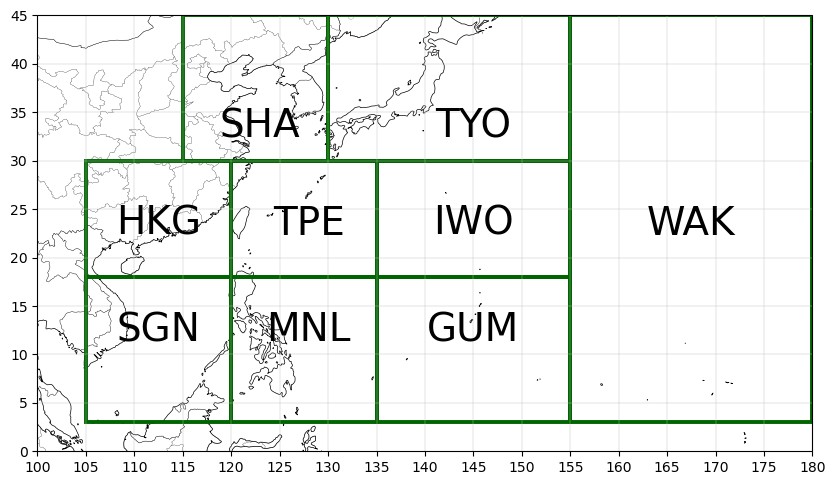

In [6]:
# Northwest Pacific Ocean Map
Fig = pyplot.figure(figsize=(10,10))
Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
Axis.coastlines(linewidth=0.5)
Axis.add_feature(cfeature.BORDERS, linewidth=0.3)
Axis.add_feature(cfeature.STATES, linewidth=0.1)
#
# Map Regions
Colours = ['greenyellow', 'limegreen', 'darkgreen', 'cyan', 'deepskyblue', 'darkviolet', \
'darkorange', 'red', 'gold']
Text_Loc = numpy.array([[112.5, 12.5], [112.5, 23.5], [123, 33.5], [128, 12.5], [128, 23.5], [145, 33.5], \
[145, 12.5], [145, 23.5], [167.5, 23.5]])
for k in range(9):
    Axis.add_patch(Rectangle((Bounds[k][2], Bounds[k][0]), Bounds[k][3]-Bounds[k][2], Bounds[k][1]-Bounds[k][0], \
    edgecolor='darkgreen', facecolor='none', linewidth=2.8))
#    pyplot.fill_between([Bounds[k][2], Bounds[k][3]], Bounds[k][0], Bounds[k][1], color=Colours[k], alpha=0.5)
    Axis.text(Text_Loc[k][0], Text_Loc[k][1], Regions[k], ha='center', va='center', fontdict={'size':28}, color='black')
#
# Formatting
x_Min = 100
x_Max = 180
y_Min = 0
y_Max = 45
x_Axis = numpy.arange(x_Min,x_Max+5,5)
y_Axis = numpy.arange(y_Min,y_Max+5,5)
Axis.set_xticks(x_Axis)
Axis.set_yticks(y_Axis)
Axis.set_xlim(x_Min,x_Max)
Axis.set_ylim(y_Min,y_Max)
Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
Gridline.xlocator = mticker.FixedLocator(x_Axis)
Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Output Fig
Fig.savefig('NW_Pac_Map.png', bbox_inches='tight')

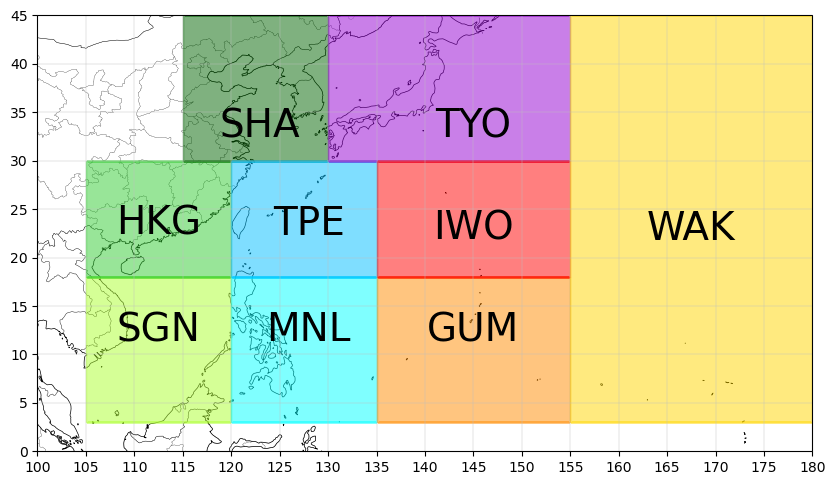

In [7]:
# Northwest Pacific Ocean Map
Fig = pyplot.figure(figsize=(10,10))
Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
Axis.coastlines(linewidth=0.5)
Axis.add_feature(cfeature.BORDERS, linewidth=0.3)
Axis.add_feature(cfeature.STATES, linewidth=0.1)
#
# Colour Regions on Map
Colours = ['greenyellow', 'limegreen', 'darkgreen', 'cyan', 'deepskyblue', 'darkviolet', \
'darkorange', 'red', 'gold']
Text_Loc = numpy.array([[112.5, 12.5], [112.5, 23.5], [123, 33.5], [128, 12.5], [128, 23.5], [145, 33.5], \
[145, 12.5], [145, 23], [167.5, 23]])
for k in range(9):
    pyplot.fill_between([Bounds[k][2], Bounds[k][3]], Bounds[k][0], Bounds[k][1], color=Colours[k], alpha=0.5)
    Axis.text(Text_Loc[k][0], Text_Loc[k][1], Regions[k], ha='center', va='center', fontdict={'size':28}, color='black')
#
# Formatting
x_Min = 100
x_Max = 180
y_Min = 0
y_Max = 45
x_Axis = numpy.arange(x_Min,x_Max+5,5)
y_Axis = numpy.arange(y_Min,y_Max+5,5)
Axis.set_xticks(x_Axis)
Axis.set_yticks(y_Axis)
Axis.set_xlim(x_Min,x_Max)
Axis.set_ylim(y_Min,y_Max)
Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
Gridline.xlocator = mticker.FixedLocator(x_Axis)
Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Output Fig
Fig.savefig('NW_Pac_Map.png', bbox_inches='tight')

In [8]:
# Find Region of Each Storm Datapoint
Region_List = []
for i in range(len(Main_DF)):
    for k in range(len(Regions)):
        S = Bounds[k][0]
        N = Bounds[k][1]
        W = Bounds[k][2]
        E = Bounds[k][3]
        if Main_DF["Lat"][i] >= S and Main_DF["Lat"][i] < N and Main_DF["Lon"][i] >= W and Main_DF["Lon"][i] < E:
            Region_List.append(Regions[k])
    if len(Region_List) < i+1:
        Region_List.append("N/A")
Main_DF["Region"] = Region_List
#Main_DF

In [9]:
# Create Dictionary to Store DataFrames For Different Regions
Region_Dict = {Regions[0]: []}
for k in range(len(Regions)):
    Region_DF = Main_DF[Main_DF["Region"] == Regions[k]].copy().reset_index()
    Region_Dict[Regions[k]] = Region_DF
#print (Region_Dict)

In [10]:
# Create DataFrames that Only Contain the Maximum Intensity for Each Storm in Each Region
Peak_Dict = {Regions[0]: []}
for k in range(len(Region_Dict)):
    Region_DF = Region_Dict[Regions[k]]
    Code_List = []
    Time_List = []
    Intensity_List = []
    Lat_List = []
    Lon_List = []
    for l in range(len(Storm_List)):
        Storm_Find = Region_DF[Region_DF["Code"] == Storm_List[l]]
        if len(Storm_Find) > 0:
            Max_Intensity = numpy.max(Storm_Find["Intensity"])
            Max_Int_Find = Storm_Find[Storm_Find["Intensity"] == Max_Intensity].copy().reset_index()
            Code_List.append(Storm_List[l])
            Intensity_List.append(Max_Intensity)
            Time_List.append(Max_Int_Find["Time"][0])
            Lat_List.append(Max_Int_Find["Lat"][0])
            Lon_List.append(Max_Int_Find["Lon"][0])
#    print (Intensity_List)
    Peak_DF = pandas.DataFrame({"Code": Code_List, "Time": Time_List, "Lat": Lat_List, "Lon": Lon_List, \
    "Intensity": Intensity_List})
    Peak_Dict[Regions[k]] = Peak_DF
#print (Peak_Dict)

In [11]:
# Find Number of Storm Count Each Year For Each Region
Storm_Count_DF = pandas.DataFrame({"Year": numpy.arange(1970,2022,1)})
for k in range(len(Regions)):
    Peak_DF = Peak_Dict[Regions[k]]
    Storm_Count_Array = numpy.zeros(52)
    for i in range(52):
        Storm_Count_Array[i] = len(Peak_DF[(Peak_DF["Time"] >= datetime(1970+i,1,1,0,0,0)) & \
        (Peak_DF["Time"] <= datetime(1970+i,12,31,23,59,0))])
    Storm_Count_DF[Regions[k]] = Storm_Count_Array
#Storm_Count_DF

In [12]:
# Find Number of Storm Hours Each Year For Each Region
Storm_Hours_DF = pandas.DataFrame({"Year": numpy.arange(1970,2022,1)})
for k in range(len(Regions)):
    Region_DF = Region_Dict[Regions[k]]
    Storm_Hours_Array = numpy.zeros(52)
    for i in range(52):
        Storm_Hours_Array[i] = len(Region_DF[(Region_DF["Time"] >= datetime(1970+i,1,1,0,0,0)) & \
        (Region_DF["Time"] <= datetime(1970+i,12,31,23,59,0))]) * 6
    Storm_Hours_DF[Regions[k]] = Storm_Hours_Array
#Storm_Hours_DF

In [13]:
# Find Intensity of the Strongest Storm For Each Year For Each Region
Intensity_DF = pandas.DataFrame({"Year": numpy.arange(1970,2022,1)})
for k in range(len(Regions)):
    Peak_DF = Peak_Dict[Regions[k]]
    Intensity_Array = numpy.zeros(52)
    for i in range(52):
        Intensities = numpy.array(Peak_DF[(Peak_DF["Time"] >= datetime(1970+i,1,1,0,0,0)) & \
        (Peak_DF["Time"] <= datetime(1970+i,12,31,23,59,0))]["Intensity"])
        if len(Intensities) > 0:
            Intensity_Array[i] = numpy.max(Intensities)
        else:
            Intensity_Array[i] = numpy.nan
    Intensity_DF[Regions[k]] = Intensity_Array
#Intensity_DF

In [14]:
# Open ENSO Index File
File = 'ONI_Index.txt'
Data = open(File, 'r')
Rows = []
#
# Organize Data
for Line in Data:
    Rows.append(Line.strip())
Years_Num = 2021-1970+1
ONI_Array = numpy.zeros((12,Years_Num+1))
for i in range(Years_Num+1):
    for j in range(12):
        ONI_Array[j][i] = float(Rows[i][6+7*j:11+7*j])
ONI_Array
#
# Crate Year List and Month List
Year_List = numpy.arange(1969,2022,1)
Month_List = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
#
# Create DataFrame to Store Data
ENSO_DF = pandas.DataFrame({"Year": Year_List})
for j in range(12):
    ENSO_DF[Month_List[j]] = ONI_Array[j]
#ENSO_DF

In [15]:
# Find Average ENSO Index From August to October and ENSO Phase
Aug_Oct_Sum = ENSO_DF["AUG"][1:] + ENSO_DF["SEP"][1:] + ENSO_DF["OCT"][1:]
Aug_Oct_Mean = numpy.array(Aug_Oct_Sum) / 3
ENSO_Phase = []
for i in range(len(Aug_Oct_Mean)):
    if Aug_Oct_Mean[i] >= 0.5:
        Phase = "El Nino"
    elif Aug_Oct_Mean[i] <= -0.5:
        Phase = "La Nina"
    else:
        Phase = "Normal"
    ENSO_Phase.append(Phase)
#
# Add Aug-Oct ENSO Index and ENSO Phase to DataFrames
Storm_Count_DF["AUG-OCT Mean"] = Aug_Oct_Mean
Storm_Count_DF["ENSO Phase"] = ENSO_Phase
Storm_Hours_DF["AUG-OCT Mean"] = Aug_Oct_Mean
Storm_Hours_DF["ENSO Phase"] = ENSO_Phase
Intensity_DF["AUG-OCT Mean"] = Aug_Oct_Mean
Intensity_DF["ENSO Phase"] = ENSO_Phase
#Storm_Hours_DF

In [16]:
# Separate DataFrames For Each ENSO Phase
El_Nino_Count_DF = Storm_Count_DF[Storm_Count_DF["ENSO Phase"] == "El Nino"]
Normal_Count_DF = Storm_Count_DF[Storm_Count_DF["ENSO Phase"] == "Normal"]
La_Nina_Count_DF = Storm_Count_DF[Storm_Count_DF["ENSO Phase"] == "La Nina"]
El_Nino_Hours_DF = Storm_Hours_DF[Storm_Hours_DF["ENSO Phase"] == "El Nino"]
Normal_Hours_DF = Storm_Hours_DF[Storm_Hours_DF["ENSO Phase"] == "Normal"]
La_Nina_Hours_DF = Storm_Hours_DF[Storm_Hours_DF["ENSO Phase"] == "La Nina"]
El_Nino_Intensity_DF = Intensity_DF[Intensity_DF["ENSO Phase"] == "El Nino"]
Normal_Intensity_DF = Intensity_DF[Intensity_DF["ENSO Phase"] == "Normal"]
La_Nina_Intensity_DF = Intensity_DF[Intensity_DF["ENSO Phase"] == "La Nina"]
#El_Nino_Intensity_DF

In [17]:
# Add ENSO Index and Phase Into Peak Dict
for k in range(len(Peak_Dict)):
    ENSO_Index_List = []
    ENSO_Phase_List = []
    Peak_DF = Peak_Dict[Regions[k]].copy()
    for m in range(len(Peak_DF)):
        Year = Peak_DF["Time"][m].year
        ENSO_Index_List.append(Storm_Count_DF["AUG-OCT Mean"][int(Year-1970)])
        ENSO_Phase_List.append(Storm_Count_DF["ENSO Phase"][int(Year-1970)])
    Peak_DF["AUG-OCT Mean"] = ENSO_Index_List
    Peak_DF["ENSO Phase"] = ENSO_Phase_List
    Peak_Dict[Regions[k]] = Peak_DF
#Peak_Dict
#
# # Separate DataFrames For Each ENSO Phase
El_Nino_Peak_Dict = {Regions[0]: []}
Normal_Peak_Dict = {Regions[0]: []}
La_Nina_Peak_Dict = {Regions[0]: []}
for k in range(len(Peak_Dict)):
    Peak_DF = Peak_Dict[Regions[k]]
    El_Nino_DF = Peak_DF[Peak_DF["ENSO Phase"] == "El Nino"]
    Normal_DF = Peak_DF[Peak_DF["ENSO Phase"] == "Normal"]
    La_Nina_DF = Peak_DF[Peak_DF["ENSO Phase"] == "La Nina"]
    El_Nino_Peak_Dict[Regions[k]] = El_Nino_DF
    Normal_Peak_Dict[Regions[k]] = Normal_DF
    La_Nina_Peak_Dict[Regions[k]] = La_Nina_DF
#El_Nino_Peak_Dict

In [18]:
# Function to Plot Cumulative Distribution Functions
def Cum_Dist(Array):
    Sorted = numpy.sort(Array)
    Len = len(Sorted)
    y_Values = numpy.arange(0,1.0001,1/(Len-1))
    return (Sorted, y_Values)

In [19]:
# Function to Create Quartile Labels
def Quart_Labels(Axis, El_Nino_Quarts, Normal_Quarts, La_Nina_Quarts, Var):
    if Var == "Storm Count":
        Axis[k][l].text(0.51, 0.10, "Q1 ", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='black')
        Axis[k][l].text(0.51, 0.20, "Med", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='black')
        Axis[k][l].text(0.51, 0.30, "Q3 ", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='black')
        Axis[k][l].text(0.59, 0.40, " Nino", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='red')
        Axis[k][l].text(0.72, 0.40, " Norm", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='darkgreen')
        Axis[k][l].text(0.85, 0.40, " Nina", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='mediumblue')
        for n in range(3):
            Axis[k][l].text(0.59, 0.10+n*0.10, str('%6.2f' % El_Nino_Quarts[n]), ha='left', va='center', \
            transform=Axis[k][l].transAxes, fontdict={'size':10}, color='red')
            Axis[k][l].text(0.72, 0.10+n*0.10, str('%6.2f' % Normal_Quarts[n]), ha='left', va='center', \
            transform=Axis[k][l].transAxes, fontdict={'size':10}, color='darkgreen')
            Axis[k][l].text(0.85, 0.10+n*0.10, str('%6.2f' % La_Nina_Quarts[n]), ha='left', va='center', \
            transform=Axis[k][l].transAxes, fontdict={'size':10}, color='mediumblue')
    if Var == "Storm Hours":
        Axis[k][l].text(0.51, 0.10, "Q1 ", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='black')
        Axis[k][l].text(0.51, 0.20, "Med", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='black')
        Axis[k][l].text(0.51, 0.30, "Q3 ", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='black')
        Axis[k][l].text(0.60, 0.40, " Nino", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='red')
        Axis[k][l].text(0.72, 0.40, " Norm", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='darkgreen')
        Axis[k][l].text(0.84, 0.40, " Nina", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='mediumblue')
        for n in range(3):
            Axis[k][l].text(0.60, 0.10+n*0.10, str('%4.0f' % El_Nino_Quarts[n]), ha='left', va='center', \
            transform=Axis[k][l].transAxes, fontdict={'size':10}, color='red')
            Axis[k][l].text(0.72, 0.10+n*0.10, str('%4.0f' % Normal_Quarts[n]), ha='left', va='center', \
            transform=Axis[k][l].transAxes, fontdict={'size':10}, color='darkgreen')
            Axis[k][l].text(0.84, 0.10+n*0.10, str('%4.0f' % La_Nina_Quarts[n]), ha='left', va='center', \
            transform=Axis[k][l].transAxes, fontdict={'size':10}, color='mediumblue')
    if Var == "Intensity":
        Axis[k][l].text(0.03, 0.60, "Q1 ", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='black')
        Axis[k][l].text(0.03, 0.70, "Med", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='black')
        Axis[k][l].text(0.03, 0.80, "Q3 ", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='black')
        Axis[k][l].text(0.12, 0.90, " Nino", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='red')
        Axis[k][l].text(0.24, 0.90, " Norm", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='darkgreen')
        Axis[k][l].text(0.36, 0.90, " Nina", ha='left', va='center', \
        transform=Axis[k][l].transAxes, fontdict={'size':10}, color='mediumblue')
        for n in range(3):
            Axis[k][l].text(0.12, 0.60+n*0.10, str('%4.0f' % El_Nino_Quarts[n]), ha='left', va='center', \
            transform=Axis[k][l].transAxes, fontdict={'size':10}, color='red')
            Axis[k][l].text(0.24, 0.60+n*0.10, str('%4.0f' % Normal_Quarts[n]), ha='left', va='center', \
            transform=Axis[k][l].transAxes, fontdict={'size':10}, color='darkgreen')
            Axis[k][l].text(0.36, 0.60+n*0.10, str('%4.0f' % La_Nina_Quarts[n]), ha='left', va='center', \
            transform=Axis[k][l].transAxes, fontdict={'size':10}, color='mediumblue')
#return (Axis)
#        String = 'Q1  ' +  + ' ' + str('%6.2f' % Normal_Quarts[n]) + ' ' + \
#        str('%6.2f' % La_Nina_Quarts[n])
#        if Var == "Storm Hours":
#            String = 'Med ' + str('%7.2f' % Quarts[n])
#        if Var == "Intensity":
#            String = str('%6.2f' % Quarts[n])
#    return (Label_Q1, Label_Med, Label_Q3)

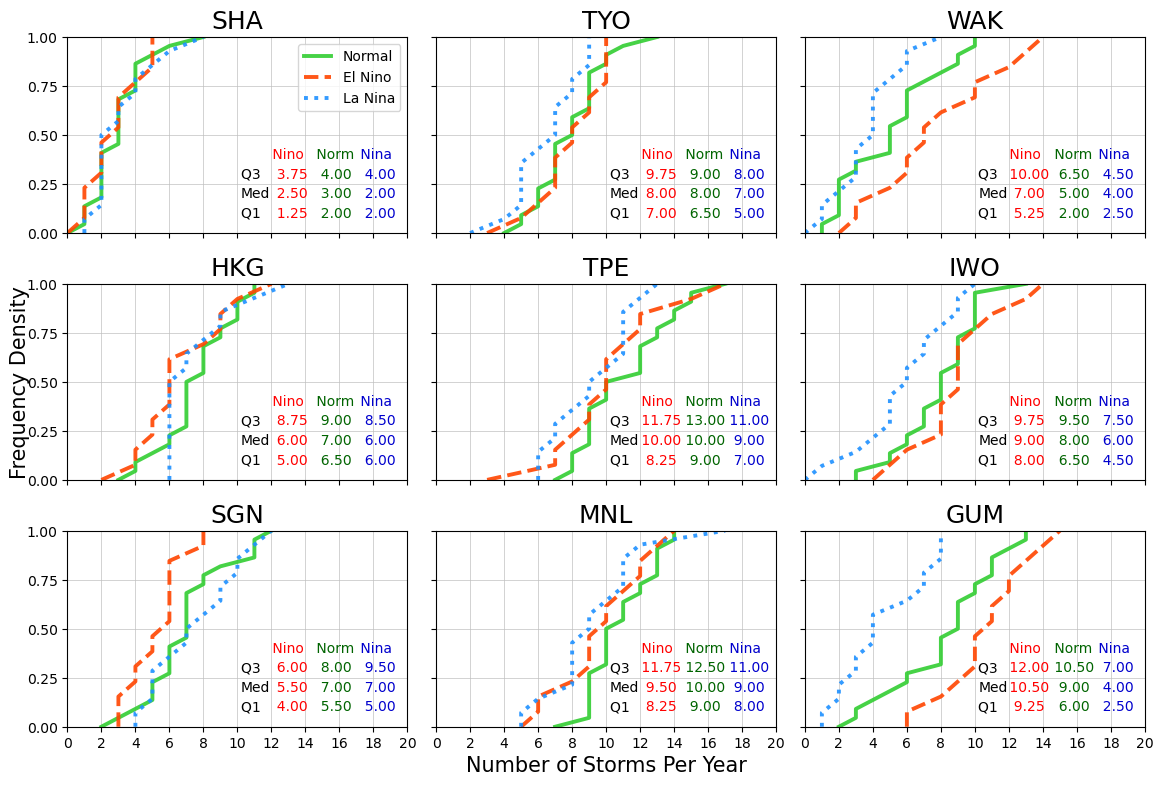

In [20]:
# Plot Number of Storm Count Cumulative Distribution Functions For Different ENSO Phase
Fig = pyplot.figure(figsize=(12,8))
Axis = Fig.subplots(3,3, sharex=True, sharey=True)
for k in range(3):
    for l in range(3):
# Normal
        Normal = numpy.array(Normal_Count_DF[Regions[(2-k)+l*3]])
        x_Values, y_Values = Cum_Dist(Normal)
        Axis[k][l].plot(x_Values, y_Values, color='limegreen', linestyle='-', linewidth=2.8, label='Normal', alpha=0.9)
# El Nino
        El_Nino = numpy.array(El_Nino_Count_DF[Regions[(2-k)+l*3]])
        x_Values, y_Values = Cum_Dist(El_Nino)
        Axis[k][l].plot(x_Values, y_Values, color='orangered', linestyle='--', linewidth=2.8, label='El Nino', alpha=0.9)
# La Nina
        La_Nina = numpy.array(La_Nina_Count_DF[Regions[(2-k)+l*3]])
        x_Values, y_Values = Cum_Dist(La_Nina)
        Axis[k][l].plot(x_Values, y_Values, color='dodgerblue', linestyle=':', linewidth=2.8, label='La Nina', alpha=0.9)
#
# Label Quartiles For Each ENSO Phase
        El_Nino_Quarts = numpy.quantile(El_Nino, [0.25,0.5,0.75])
        Normal_Quarts = numpy.quantile(Normal, [0.25,0.5,0.75])
        La_Nina_Quarts = numpy.quantile(La_Nina, [0.25,0.5,0.75])
        Quart_Labels(Axis, El_Nino_Quarts, Normal_Quarts, La_Nina_Quarts, "Storm Count")
#
# Formatting
        Axis[k][l].set_title(Regions[(2-k)+l*3], fontsize=18)
        Axis[k][l].set_xlim(0,20)
        Axis[k][l].set_xticks(numpy.arange(0,22,2))
        Axis[k][l].set_ylim(0,1)
        Axis[k][l].set_yticks(numpy.arange(0,1.25,0.25))
        Gridline = Axis[k][l].grid(linewidth=0.5, color='silver', linestyle='-')
        if k == 0 and l == 0:
            Axis[k][l].legend(loc=1)
Fig.add_subplot(111, frameon=False)
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.tight_layout()
pyplot.xlabel('Number of Storms Per Year', fontsize=15)
pyplot.ylabel('Frequency Density', fontsize=15)
#
# Output Fig
Fig.savefig('Freq_Dense_Storm_Count.png', bbox_inches='tight')

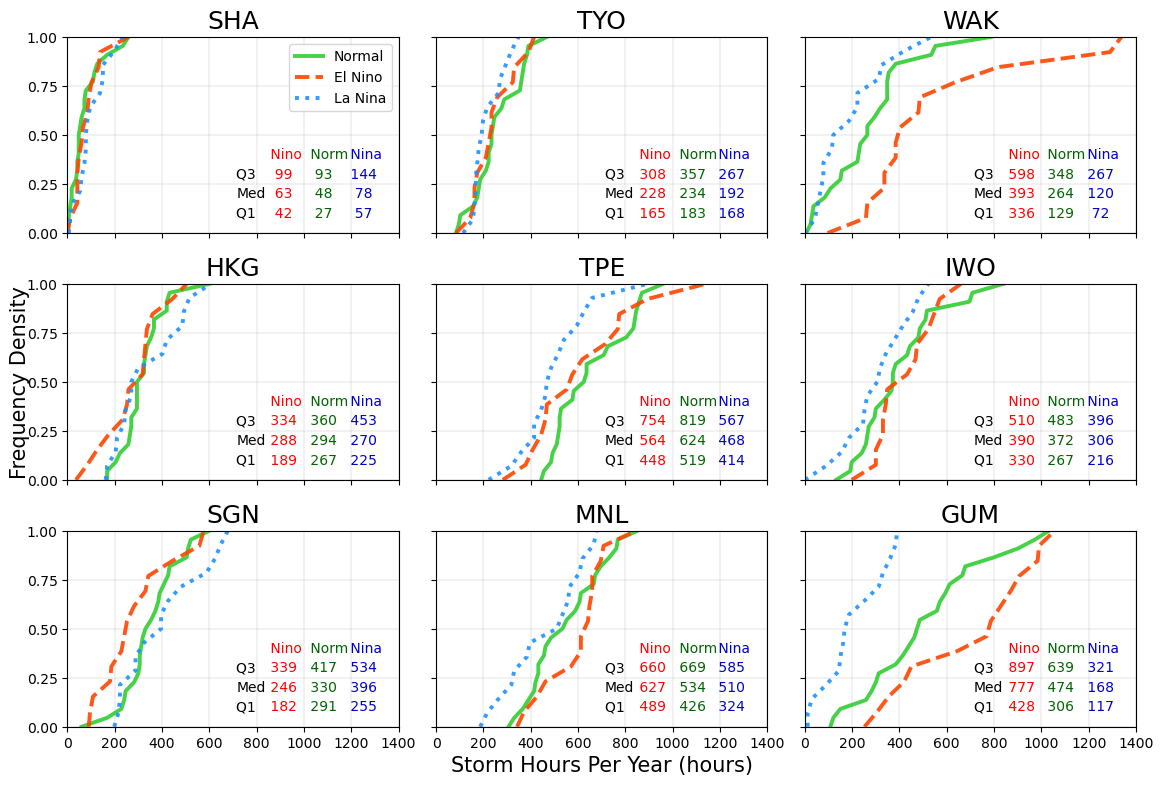

In [21]:
# Plot Number of Storm Hours Cumulative Distribution Functions For Different ENSO Phase
Fig = pyplot.figure(figsize=(12,8))
Axis = Fig.subplots(3,3, sharex=True, sharey=True)
for k in range(3):
    for l in range(3):
# Normal
        Normal = numpy.array(Normal_Hours_DF[Regions[(2-k)+l*3]])
        x_Values, y_Values = Cum_Dist(Normal)
        Axis[k][l].plot(x_Values, y_Values, color='limegreen', linestyle='-', linewidth=2.8, label='Normal', alpha=0.9)
# El Nino
        El_Nino = numpy.array(El_Nino_Hours_DF[Regions[(2-k)+l*3]])
        x_Values, y_Values = Cum_Dist(El_Nino)
        Axis[k][l].plot(x_Values, y_Values, color='orangered', linestyle='--', linewidth=2.8, label='El Nino', alpha=0.9)
# La Nina
        La_Nina = numpy.array(La_Nina_Hours_DF[Regions[(2-k)+l*3]])
        x_Values, y_Values = Cum_Dist(La_Nina)
        Axis[k][l].plot(x_Values, y_Values, color='dodgerblue', linestyle=':', linewidth=2.8, label='La Nina', alpha=0.9)
#
# Label Quartiles For Each ENSO Phase
        El_Nino_Quarts = numpy.quantile(El_Nino, [0.25,0.5,0.75])
        Normal_Quarts = numpy.quantile(Normal, [0.25,0.5,0.75])
        La_Nina_Quarts = numpy.quantile(La_Nina, [0.25,0.5,0.75])
        Quart_Labels(Axis, El_Nino_Quarts, Normal_Quarts, La_Nina_Quarts, "Storm Hours")
#
# Formatting
        Axis[k][l].set_title(Regions[(2-k)+l*3], fontsize=18)
        Axis[k][l].set_xlim(0,1400)
        Axis[k][l].set_xticks(numpy.arange(0,1600,200))
        Axis[k][l].set_ylim(0,1)
        Axis[k][l].set_yticks(numpy.arange(0,1.25,0.25))
        Gridline = Axis[k][l].grid(linewidth=0.3, color='silver', linestyle='-')
        if k == 0 and l == 0:
            Axis[k][l].legend(loc=1)
Fig.add_subplot(111, frameon=False)
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.tight_layout()
pyplot.xlabel('Storm Hours Per Year (hours)', fontsize=15)
pyplot.ylabel('Frequency Density', fontsize=15)
#
# Output Fig
Fig.savefig('Freq_Dense_Storm_Hours.png', bbox_inches='tight')

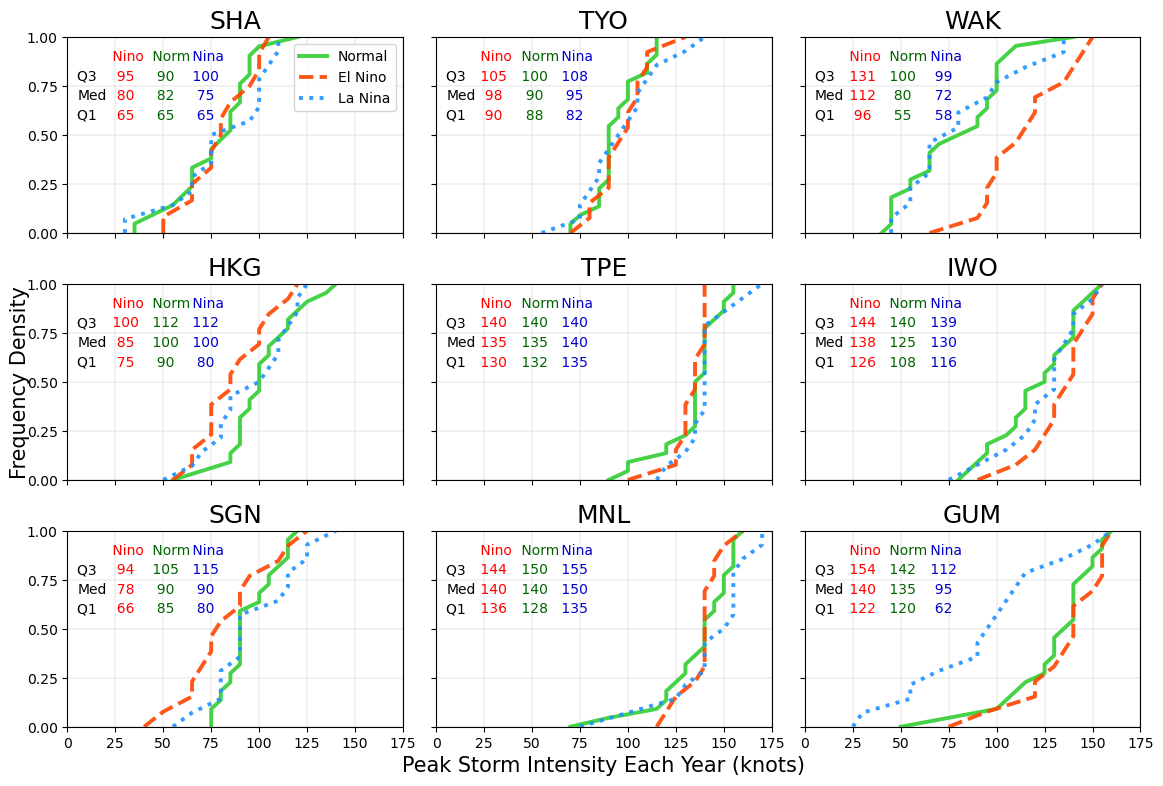

In [22]:
# Plot Peak Intensity Cumulative Distribution Functions For Different ENSO Phase
Fig = pyplot.figure(figsize=(12,8))
Axis = Fig.subplots(3,3, sharex=True, sharey=True)
for k in range(3):
    for l in range(3):
# Normal
        Normal_Finite = Normal_Intensity_DF[numpy.isfinite(Normal_Intensity_DF[Regions[(2-k)+l*3]])]
        Normal = numpy.array(Normal_Finite[Regions[(2-k)+l*3]])
        x_Values, y_Values = Cum_Dist(Normal)
        Axis[k][l].plot(x_Values, y_Values, color='limegreen', linestyle='-', linewidth=2.8, label='Normal', alpha=0.9)
# El Nino
        El_Nino_Finite = El_Nino_Intensity_DF[numpy.isfinite(El_Nino_Intensity_DF[Regions[(2-k)+l*3]])]
        El_Nino = numpy.array(El_Nino_Finite[Regions[(2-k)+l*3]])
        x_Values, y_Values = Cum_Dist(El_Nino)
        Axis[k][l].plot(x_Values, y_Values, color='orangered', linestyle='--', linewidth=2.8, label='El Nino', alpha=0.9)
# La Nina
        La_Nina_Finite = La_Nina_Intensity_DF[numpy.isfinite(La_Nina_Intensity_DF[Regions[(2-k)+l*3]])]
        La_Nina = numpy.array(La_Nina_Finite[Regions[(2-k)+l*3]])
        x_Values, y_Values = Cum_Dist(La_Nina)
        Axis[k][l].plot(x_Values, y_Values, color='dodgerblue', linestyle=':', linewidth=2.8, label='La Nina', alpha=0.9)
#
# Label Quartiles For Each ENSO Phase
        El_Nino_Quarts = numpy.quantile(El_Nino, [0.25,0.5,0.75])
        Normal_Quarts = numpy.quantile(Normal, [0.25,0.5,0.75])
        La_Nina_Quarts = numpy.quantile(La_Nina, [0.25,0.5,0.75])
        Quart_Labels(Axis, El_Nino_Quarts, Normal_Quarts, La_Nina_Quarts, "Intensity")
#
# Formatting
        Axis[k][l].set_title(Regions[(2-k)+l*3], fontsize=18)
        Axis[k][l].set_xlim(0,175)
        Axis[k][l].set_xticks(numpy.arange(0,200,25))
        Axis[k][l].set_ylim(0,1)
        Axis[k][l].set_yticks(numpy.arange(0,1.25,0.25))
        Gridline = Axis[k][l].grid(linewidth=0.3, color='silver', linestyle='-')
        if k == 0 and l == 0:
            Axis[k][l].legend(loc=1)
Fig.add_subplot(111, frameon=False)
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.tight_layout()
pyplot.xlabel('Peak Storm Intensity Each Year (knots)', fontsize=15)
pyplot.ylabel('Frequency Density', fontsize=15)
#
# Output Fig
Fig.savefig('Freq_Dense_Intensity.png', bbox_inches='tight')

In [23]:
# Create Function to Calculate Correlation Coefficient and Significance
def Corr_Coef(x,y):
    Reg = numpy.polyfit(x, y, 1)
# Calculate Slope and Intercept
    Slope = Reg[0]
    Intercept = Reg[1]
#
# Calculate Correlation Coefficient
    Corr = scipy.stats.pearsonr(x,y)[0]
#
# Calculate P Value
    P_Value = scipy.stats.pearsonr(x,y)[1]
    return (Slope, Intercept, Corr, P_Value)

In [24]:
# Calculate OLS Correlation Coefficient Between Storm Count and ENSO Index
Storm_Count_Corr = numpy.zeros((9,4))
for k in range(9):
    Storm_Count_Corr[k] = Corr_Coef(Storm_Count_DF["AUG-OCT Mean"], Storm_Count_DF[Regions[k]])
#    print (Storm_Count_Corr[k][3])
#print (Storm_Count_Corr)

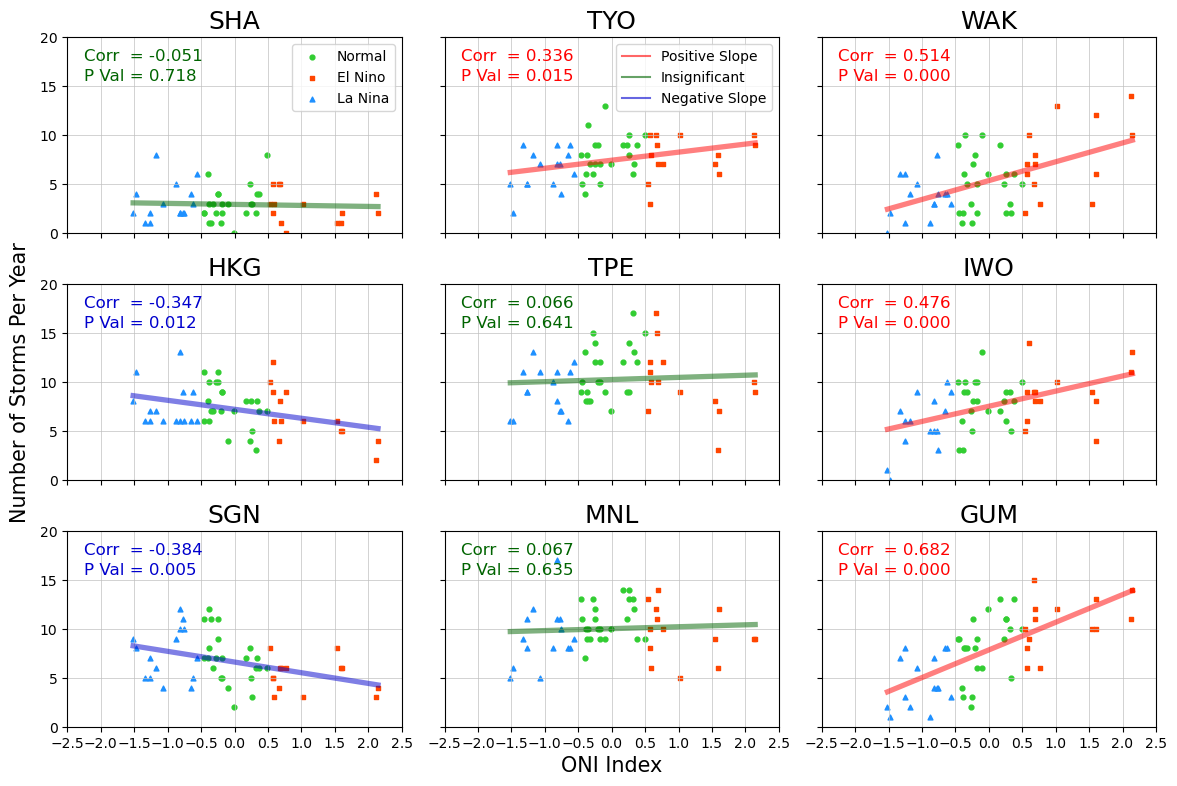

In [25]:
# Plot ENSO Index VS Storm Count
Fig = pyplot.figure(figsize=(12,8))
Axis = Fig.subplots(3,3, sharex=True, sharey=True)
for k in range(3):
    for l in range(3):
# Plot Points With Colour According to ENSO Phase
        Axis[k][l].scatter(Normal_Count_DF["AUG-OCT Mean"], Normal_Count_DF[Regions[(2-k)+l*3]], \
        color='limegreen', marker='o', s=12, label='Normal')
        Axis[k][l].scatter(El_Nino_Count_DF["AUG-OCT Mean"], El_Nino_Count_DF[Regions[(2-k)+l*3]], \
        color='orangered', marker='s', s=12, label='El Nino')
        Axis[k][l].scatter(La_Nina_Count_DF["AUG-OCT Mean"], La_Nina_Count_DF[Regions[(2-k)+l*3]], \
        color='dodgerblue', marker='^', s=12, label='La Nina')
#
# Plot OLS Regression Line
        x_Min = numpy.min(Storm_Count_DF["AUG-OCT Mean"])
        x_Max = numpy.max(Storm_Count_DF["AUG-OCT Mean"])
        y_Min = x_Min*Storm_Count_Corr[(2-k)+l*3][0]+Storm_Count_Corr[(2-k)+l*3][1]
        y_Max = x_Max*Storm_Count_Corr[(2-k)+l*3][0]+Storm_Count_Corr[(2-k)+l*3][1]
        if Storm_Count_Corr[(2-k)+l*3][3] <= 0.05:
            if Storm_Count_Corr[(2-k)+l*3][2] > 0:
                Line_Colour = 'red'
            if Storm_Count_Corr[(2-k)+l*3][2] < 0:
                Line_Colour = 'mediumblue'
        else:
            Line_Colour = 'darkgreen'
        Axis[k][l].plot([x_Min, x_Max], [y_Min, y_Max], color=Line_Colour, linewidth=3.8, alpha=0.5)
#
# Label Correlation Coefficient and P Value
        Axis[k][l].text(0.05, 0.90, "Corr  = " + str('%5.3f' % Storm_Count_Corr[(2-k)+l*3][2]), \
        ha='left', va='center', transform=Axis[k][l].transAxes, fontdict={'size':12}, color=Line_Colour)
        Axis[k][l].text(0.05, 0.80, "P Val = " + str('%5.3f' % Storm_Count_Corr[(2-k)+l*3][3]), \
        ha='left', va='center', transform=Axis[k][l].transAxes, fontdict={'size':12}, color=Line_Colour)
#
# Formatting
        Axis[k][l].set_title(Regions[(2-k)+l*3], fontsize=18)
        Axis[k][l].set_xlim(-2.5,2.5)
        Axis[k][l].set_xticks(numpy.arange(-2.5,3,0.5))
        Axis[k][l].set_ylim(0,20)
        Axis[k][l].set_yticks(numpy.arange(0,25,5))
        Gridline = Axis[k][l].grid(linewidth=0.5, color='silver', linestyle='-')
        if k == 0 and l == 0:
            Axis[k][l].legend(loc=1)
        if k == 0 and l == 1:
            L1, = Axis[k][l].plot([-728],[-728], color='red', label='Positive Slope', alpha=0.6)
            L2, = Axis[k][l].plot([-728],[-728], color='darkgreen', label='Insignificant', alpha=0.6)
            L3, = Axis[k][l].plot([-728],[-728], color='mediumblue', label='Negative Slope', alpha=0.6)
            Axis[k][l].legend(handles=[L1,L2,L3], loc=1)
Fig.add_subplot(111, frameon=False)
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.tight_layout()
pyplot.xlabel('ONI Index', fontsize=15)
pyplot.ylabel('Number of Storms Per Year', fontsize=15)
#
# Output Fig
Fig.savefig('Corr_Storm_Count.png', bbox_inches='tight')

In [26]:
# Calculate OLS Correlation Coefficient Between Storm Hours and ENSO Index
Storm_Hours_Corr = numpy.zeros((9,4))
for k in range(9):
    Storm_Hours_Corr[k] = Corr_Coef(Storm_Hours_DF["AUG-OCT Mean"], Storm_Hours_DF[Regions[k]])
#    print (Storm_Hours_Corr[k][3])
#print (Storm_Hours_Corr)

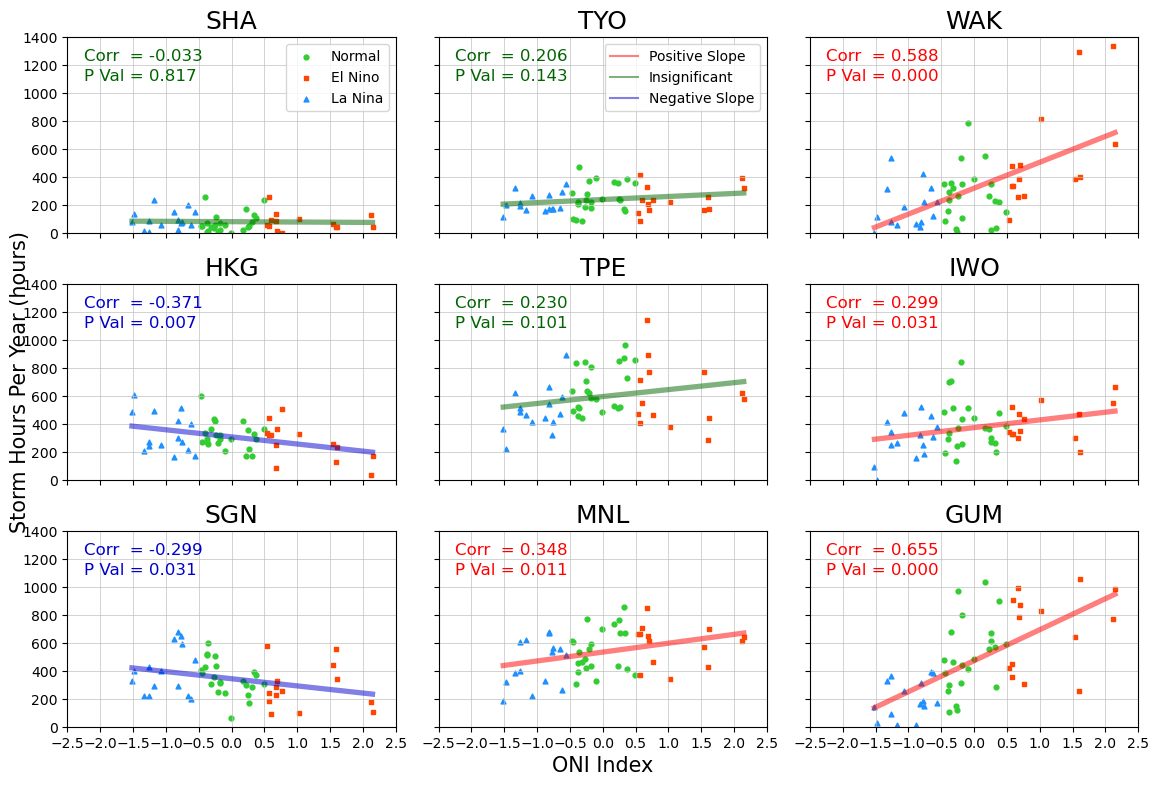

In [27]:
# Plot ENSO Index VS Storm Hours
Fig = pyplot.figure(figsize=(12,8))
Axis = Fig.subplots(3,3, sharex=True, sharey=True)
for k in range(3):
    for l in range(3):
# Plot Points With Colour According to ENSO Phase
        Axis[k][l].scatter(Normal_Hours_DF["AUG-OCT Mean"], Normal_Hours_DF[Regions[(2-k)+l*3]], \
        color='limegreen', marker='o', s=12, label='Normal')
        Axis[k][l].scatter(El_Nino_Hours_DF["AUG-OCT Mean"], El_Nino_Hours_DF[Regions[(2-k)+l*3]], \
        color='orangered', marker='s', s=12, label='El Nino')
        Axis[k][l].scatter(La_Nina_Hours_DF["AUG-OCT Mean"], La_Nina_Hours_DF[Regions[(2-k)+l*3]], \
        color='dodgerblue', marker='^', s=12, label='La Nina')
#
# Plot OLS Regression Line
        x_Min = numpy.min(Storm_Hours_DF["AUG-OCT Mean"])
        x_Max = numpy.max(Storm_Hours_DF["AUG-OCT Mean"])
        y_Min = x_Min*Storm_Hours_Corr[(2-k)+l*3][0]+Storm_Hours_Corr[(2-k)+l*3][1]
        y_Max = x_Max*Storm_Hours_Corr[(2-k)+l*3][0]+Storm_Hours_Corr[(2-k)+l*3][1]
        if Storm_Hours_Corr[(2-k)+l*3][3] <= 0.05:
            if Storm_Hours_Corr[(2-k)+l*3][2] > 0:
                Line_Colour = 'red'
            if Storm_Hours_Corr[(2-k)+l*3][2] < 0:
                Line_Colour = 'mediumblue'
        else:
            Line_Colour = 'darkgreen'
        Axis[k][l].plot([x_Min, x_Max], [y_Min, y_Max], c=Line_Colour, linewidth=3.8, alpha=0.5)
#
# Label Correlation Coefficient and P Value
        Axis[k][l].text(0.05, 0.90, "Corr  = " + str('%5.3f' % Storm_Hours_Corr[(2-k)+l*3][2]), \
        ha='left', va='center', transform=Axis[k][l].transAxes, fontdict={'size':12}, color=Line_Colour)
        Axis[k][l].text(0.05, 0.80, "P Val = " + str('%5.3f' % Storm_Hours_Corr[(2-k)+l*3][3]), \
        ha='left', va='center', transform=Axis[k][l].transAxes, fontdict={'size':12}, color=Line_Colour)
#
# Formatting
        Axis[k][l].set_title(Regions[(2-k)+l*3], fontsize=18)
        Axis[k][l].set_xlim(-2.5,2.5)
        Axis[k][l].set_xticks(numpy.arange(-2.5,3,0.5))
        Axis[k][l].set_ylim(0,1400)
        Axis[k][l].set_yticks(numpy.arange(0,1600,200))
        Gridline = Axis[k][l].grid(linewidth=0.5, color='silver', linestyle='-')
        if k == 0 and l == 0:
            Axis[k][l].legend(loc=1)
        if k == 0 and l == 1:
            L1, = Axis[k][l].plot([-728],[-728], color='red', label='Positive Slope', alpha=0.5)
            L2, = Axis[k][l].plot([-728],[-728], color='darkgreen', label='Insignificant', alpha=0.5)
            L3, = Axis[k][l].plot([-728],[-728], color='mediumblue', label='Negative Slope', alpha=0.5)
            Axis[k][l].legend(handles=[L1,L2,L3], loc=1)
Fig.add_subplot(111, frameon=False)
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.tight_layout()
pyplot.xlabel('ONI Index', fontsize=15)
pyplot.ylabel('Storm Hours Per Year (hours)', fontsize=15)
#
# Output Fig
Fig.savefig('Corr_Storm_Hours.png', bbox_inches='tight')

In [28]:
# Calculate OLS Correlation Coefficient Between Peak Intensity and ENSO Index
Intensity_Corr = numpy.zeros((9,4))
for k in range(9):
    Finite_DF = Intensity_DF[numpy.isfinite(Intensity_DF[Regions[k]])]
    Intensity_Corr[k] = Corr_Coef(Finite_DF["AUG-OCT Mean"], Finite_DF[Regions[k]])
#    print (Intensity_Corr[k][3])
#print (Intensity_Corr)

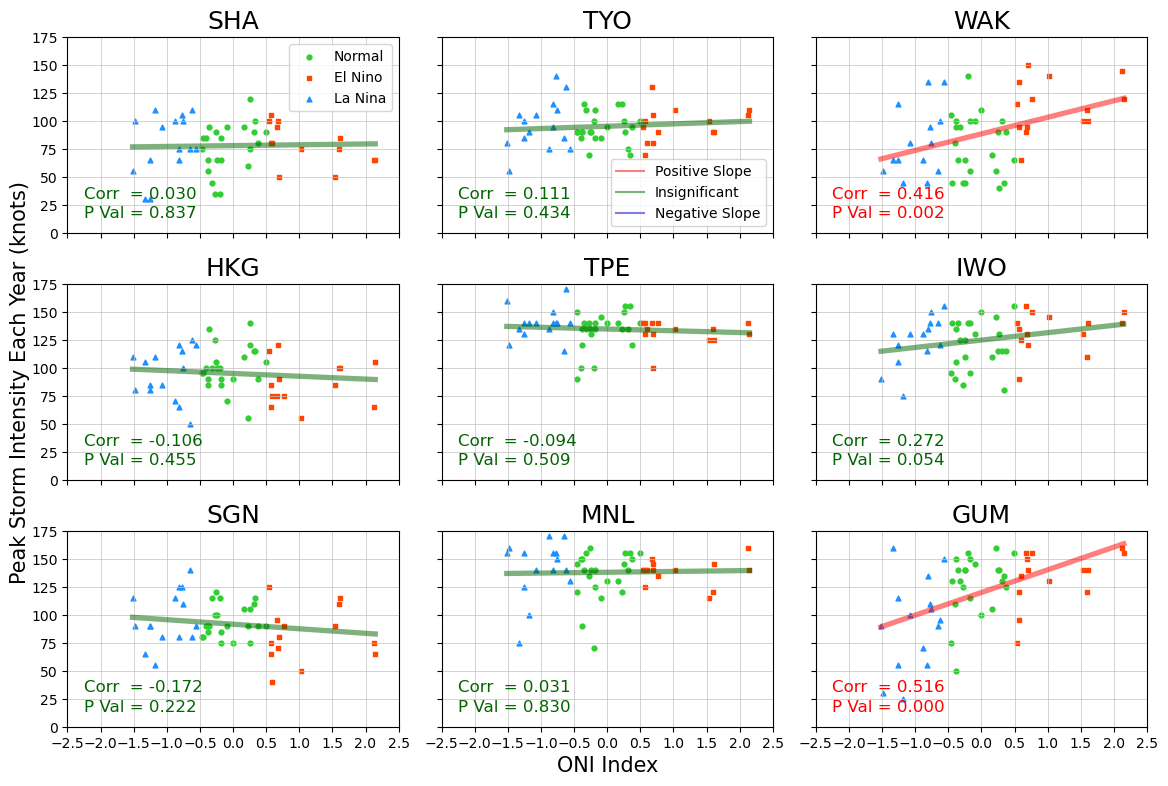

In [29]:
# Plot ENSO Index VS Peak Intensity
Fig = pyplot.figure(figsize=(12,8))
Axis = Fig.subplots(3,3, sharex=True, sharey=True)
for k in range(3):
    for l in range(3):
# Plot Points With Colour According to ENSO Phase
        El_Nino_Finite_DF = El_Nino_Intensity_DF[numpy.isfinite(El_Nino_Intensity_DF[Regions[(2-k)+l*3]])]
        Normal_Finite_DF = Normal_Intensity_DF[numpy.isfinite(Normal_Intensity_DF[Regions[(2-k)+l*3]])]
        La_Nina_Finite_DF = La_Nina_Intensity_DF[numpy.isfinite(La_Nina_Intensity_DF[Regions[(2-k)+l*3]])]
        Axis[k][l].scatter(Normal_Finite_DF["AUG-OCT Mean"], Normal_Finite_DF[Regions[(2-k)+l*3]], \
        color='limegreen', marker='o', s=12, label='Normal')
        Axis[k][l].scatter(El_Nino_Finite_DF["AUG-OCT Mean"], El_Nino_Finite_DF[Regions[(2-k)+l*3]], \
        color='orangered', marker='s', s=12, label='El Nino')
        Axis[k][l].scatter(La_Nina_Finite_DF["AUG-OCT Mean"], La_Nina_Finite_DF[Regions[(2-k)+l*3]], \
        color='dodgerblue', marker='^', s=12, label='La Nina')
#
# Plot OLS Regression Line
        x_Min = numpy.min(Intensity_DF["AUG-OCT Mean"])
        x_Max = numpy.max(Intensity_DF["AUG-OCT Mean"])
        y_Min = x_Min*Intensity_Corr[(2-k)+l*3][0]+Intensity_Corr[(2-k)+l*3][1]
        y_Max = x_Max*Intensity_Corr[(2-k)+l*3][0]+Intensity_Corr[(2-k)+l*3][1]
        if Intensity_Corr[(2-k)+l*3][3] <= 0.05:
            if Intensity_Corr[(2-k)+l*3][2] > 0:
                Line_Colour = 'red'
            if Intensity_Corr[(2-k)+l*3][2] < 0:
                Line_Colour = 'mediumblue'
        else:
            Line_Colour = 'darkgreen'
        Axis[k][l].plot([x_Min, x_Max], [y_Min, y_Max], c=Line_Colour, linewidth=3.8, alpha=0.5)
#
# Label Correlation Coefficient and P Value
        Axis[k][l].text(0.05, 0.20, "Corr  = " + str('%5.3f' % Intensity_Corr[(2-k)+l*3][2]), \
        ha='left', va='center', transform=Axis[k][l].transAxes, fontdict={'size':12}, color=Line_Colour)
        Axis[k][l].text(0.05, 0.10, "P Val = " + str('%5.3f' % Intensity_Corr[(2-k)+l*3][3]), \
        ha='left', va='center', transform=Axis[k][l].transAxes, fontdict={'size':12}, color=Line_Colour)
#
# Formatting
        Axis[k][l].set_title(Regions[(2-k)+l*3], fontsize=18)
        Axis[k][l].set_xlim(-2.5,2.5)
        Axis[k][l].set_xticks(numpy.arange(-2.5,3,0.5))
        Axis[k][l].set_ylim(0,175)
        Axis[k][l].set_yticks(numpy.arange(0,200,25))
        Gridline = Axis[k][l].grid(linewidth=0.5, color='silver', linestyle='-')
        if k == 0 and l == 0:
            Axis[k][l].legend(loc=1)
        if k == 0 and l == 1:
            L1, = Axis[k][l].plot([-728],[-728], color='red', label='Positive Slope', alpha=0.5)
            L2, = Axis[k][l].plot([-728],[-728], color='darkgreen', label='Insignificant', alpha=0.5)
            L3, = Axis[k][l].plot([-728],[-728], color='mediumblue', label='Negative Slope', alpha=0.5)
            Axis[k][l].legend(handles=[L1,L2,L3], loc=4)
Fig.add_subplot(111, frameon=False)
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.tight_layout()
pyplot.xlabel('ONI Index', fontsize=15)
pyplot.ylabel('Peak Storm Intensity Each Year (knots)', fontsize=15)
#
# Output Fig
Fig.savefig('Corr_Intensity.png', bbox_inches='tight')

In [30]:
print (Storm_Count_Corr)
print (Storm_Hours_Corr)
print (Intensity_Corr)

[[-1.09054647e+00  6.60106011e+00 -3.84442173e-01  4.89464621e-03]
 [-9.15120210e-01  7.20261169e+00 -3.46792306e-01  1.17801415e-02]
 [-1.03048818e-01  2.91990619e+00 -5.12673435e-02  7.18140798e-01]
 [ 1.95568946e-01  1.00060175e+01  6.74793131e-02  6.34563275e-01]
 [ 2.18994145e-01  1.02375075e+01  6.61473813e-02  6.41279133e-01]
 [ 8.21646466e-01  7.42912758e+00  3.35885737e-01  1.49159235e-02]
 [ 2.82019022e+00  7.83677508e+00  6.82064074e-01  2.58150729e-08]
 [ 1.54494732e+00  7.50907530e+00  4.75691627e-01  3.65159726e-04]
 [ 1.92148906e+00  5.34758428e+00  5.13858519e-01  9.76770632e-05]]
[[-5.11709485e+01  3.42733202e+02 -2.99182157e-01  3.11925712e-02]
 [-5.08600311e+01  3.06973538e+02 -3.71407602e-01  6.71073680e-03]
 [-2.49609731e+00  8.09231970e+01 -3.29074798e-02  8.16853857e-01]
 [ 6.34003813e+01  5.33066166e+02  3.48349229e-01  1.13824252e-02]
 [ 4.96169841e+01  5.95180523e+02  2.29938387e-01  1.01034748e-01]
 [ 2.16569108e+01  2.39281751e+02  2.05997067e-01  1.42887871

In [44]:
# Define Colour in Northwest Pacific Ocean Map Based on Correlation Coefficient
Map_Colours = []
for n in range(3):
    Map_Colours.append([])
    if n == 0:
        Corr_Array = Storm_Count_Corr
    if n == 1:
        Corr_Array = Storm_Hours_Corr
    if n == 2:
        Corr_Array = Intensity_Corr
    Corr_Coefs = Corr_Array[:,2]
    P_Vals = Corr_Array[:,3]
    for k in range(9):
# If Significant        
        if P_Vals[k] <= 0.05:
# If Slope Positive
            if Corr_Coefs[k] > 0:
#                El_Nino_Colours = ['orange', 'red', 'firebrick']
#                El_Nino_Bounds = [0.30,0.50]
                if Corr_Coefs[k] < 0.30:
                    Map_Colours[n].append('orange')
                elif Corr_Coefs[k] < 0.50:
                    Map_Colours[n].append('orangered')
                else:
                    Map_Colours[n].append('red')
# If Slope Negative
            if Corr_Coefs[k] < 0:
                if Corr_Coefs[k] > -0.30:
                    Map_Colours[n].append('deepskyblue')
                elif Corr_Coefs[k] > -0.50:
                    Map_Colours[n].append('dodgerblue')
                else:
                    Map_Colours[n].append('mediumblue')
# If Insignificant
        else:
            if Corr_Coefs[k] < -0.10:
                Map_Colours[n].append('forestgreen')
            elif Corr_Coefs[k] < 0.10:
                Map_Colours[n].append('limegreen')
            else:
                Map_Colours[n].append('greenyellow')
print (Map_Colours)

[['dodgerblue', 'dodgerblue', 'limegreen', 'limegreen', 'limegreen', 'orangered', 'red', 'orangered', 'red'], ['deepskyblue', 'dodgerblue', 'limegreen', 'orangered', 'greenyellow', 'greenyellow', 'red', 'orange', 'red'], ['forestgreen', 'forestgreen', 'limegreen', 'limegreen', 'limegreen', 'greenyellow', 'red', 'greenyellow', 'orangered']]


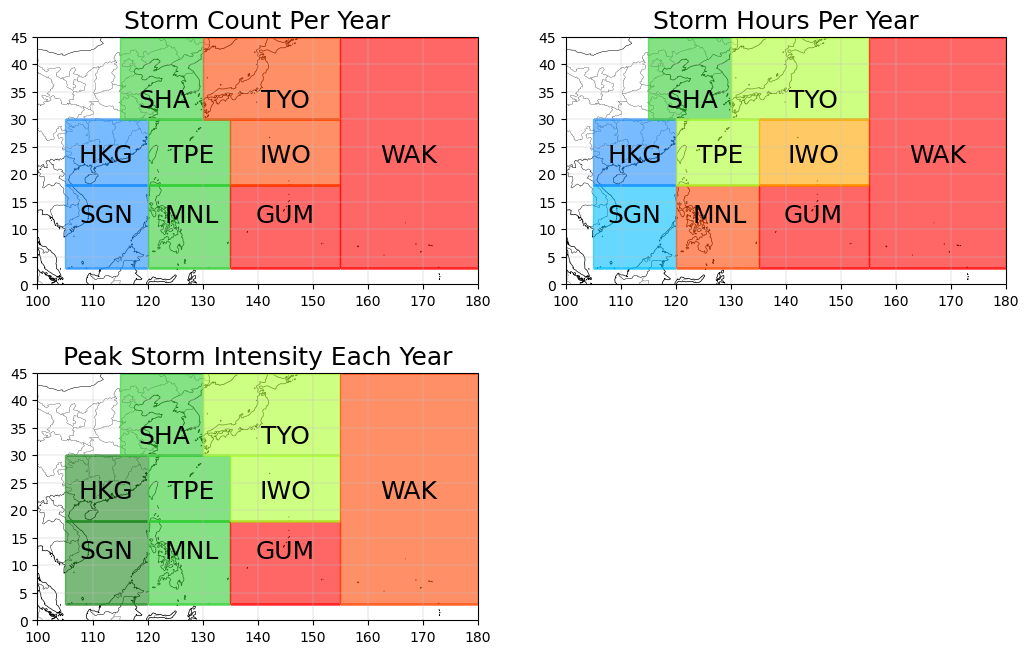

In [46]:
# Northwest Pacific Ocean Map
Fig = pyplot.figure(figsize=(12.5,8))
#Axis = Fig.subplots(3,3, projection=ccrs.PlateCarree())
for n in range(3):
    Axis = Fig.add_subplot(2,2,n+1, projection=ccrs.PlateCarree())
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.3)
    Axis.add_feature(cfeature.STATES, linewidth=0.1)
#
# Map Regions
    Text_Loc = numpy.array([[112.5, 12.5], [112.5, 23.5], [123, 33.5], [128, 12.5], [128, 23.5], [145, 33.5], \
    [145, 12.5], [145, 23.5], [167.5, 23.5]])
    for k in range(9):
#        Axis.add_patch(Rectangle((Bounds[k][2], Bounds[k][0]), Bounds[k][3]-Bounds[k][2], Bounds[k][1]-Bounds[k][0], \
#        edgecolor='darkgreen', facecolor='none', linewidth=2.8))
        pyplot.fill_between([Bounds[k][2], Bounds[k][3]], Bounds[k][0], Bounds[k][1], color=Map_Colours[n][k], alpha=0.6)
        Axis.text(Text_Loc[k][0], Text_Loc[k][1], Regions[k], ha='center', va='center', fontdict={'size':18}, color='black')
#
# Formatting
    Titles = ["Storm Count Per Year", "Storm Hours Per Year", "Peak Storm Intensity Each Year"]
    Axis.set_title(Titles[n], fontsize=18)
    x_Min = 100
    x_Max = 180
    y_Min = 0
    y_Max = 45
    x_Axis = numpy.arange(x_Min,x_Max+10,10)
    y_Axis = numpy.arange(y_Min,y_Max+5,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Output Fig
#ßFig.savefig('NW_Pac_Map.png', bbox_inches='tight')